In [202]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
from datetime import datetime
import plotly.express as px
import math
import warnings
warnings.filterwarnings('ignore')
import time
from time import perf_counter
import glob
import csv
import importlib
import seaborn as sns
import json
from tqdm.notebook import tqdm
import sys
sys.path.append('C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/notebook/tweet_utils')
import tweets_utils
%autosave 3600

Autosaving every 3600 seconds


# Motivazioni
<p>
    
    Le motivazioni per la scelta di questi 12 nuovi utenti si basa su uno studio analogo a quanto fatto per i dozen dalla CCDH.
    
    Dal momento che non viene specificato di quale tipo di attività sono responsabili (tweet/retweet generati) si è scelto di estrarre le gli utenti che fanno "good information" e sono attivi sia tra i retweettati che post originali
    https://www.ucl.ac.uk/oppenheim/Covid-19_tweeps.shtml
</p>

# Indice  
### Comparison Dozen and High credibility verified user
   - [Stats](#c_stats)
   - [Original](#original)
   - [Quote](#quote)
   - [Retweetted users](#rt)
   - [Most shared tweets](#mst)
   - [Link shared](#link_sh)
   - [Youtube Domain Shared](#yt)
       - [Bad](#bad_yt)
       - [Good](#good_yt)
       - [SAGE description](#sage_yt)
   - [Facebook](#fb)
   - [Comparison hashtag](#comp_hashtag)
   
   <br>
   
   - [Dozen Followers](#follow)
   - [Link shared](#dm)
   - [Comparison hashtag](#hs)
   - [Credibility comparison](#cred_comp)
   - [Novax Score](#nova)
   
   <br>
   
   - [Interaction check](#interaction)
   - [Reply investigation](#reply_inv)
   - [File Botometer](#bom)
   - [Regression: Degree - Score](#degscore)
   - [SAGE](#sage)
   - [Avaxtar](#avaxtar)

In [2]:
path_url = glob.glob("F:/Supsi/COVID-19-Tweets/large_files/urls/expanded_urls_*.csv")
expanded_urls = pd.DataFrame()
for i in path_url:
    expanded_urls = expanded_urls.append(pd.read_csv(i, low_memory=False, lineterminator="\n"))
    expanded_urls = expanded_urls[expanded_urls["expanded"].notna()]
    expanded_urls.drop('error', inplace=True, axis=1)
    expanded_urls.drop_duplicates(subset=['url'])
expanded_urls.reset_index(drop=True)
expanded_urls

,url,expanded
0,https://bit.ly/38SLstI,https://news.abs-cbn.com/news/01/29/20/cbcp-is...
1,http://dlvr.it/RP1y3X,https://www.theglobeandmail.com/world/article-...
2,https://trib.al/aYQ7ZIA,https://www.dailymail.co.uk/news/article-79390...
3,http://bit.ly/2tMEBmu,https://www.who.int/news-room/q-a-detail/q-a-c...
4,http://bit.ly/36HK7Vk,https://cnnphilippines.com/news/2020/1/31/pers...
...,...,...
49806,https://www.irishtimes.com/news/social-affairs...,https://www.irishtimes.com/news/social-affairs...
49807,https://www.irishtimes.com/news/social-affairs...,https://www.irishtimes.com/news/social-affairs...
49808,https://www.irishtimes.com/news/social-affairs...,https://www.irishtimes.com/news/social-affairs...
49809,https://www.irishtimes.com/news/social-affairs...,https://www.irishtimes.com/news/social-affairs...


In [3]:
cols = ["id", "id_str", "user_id", "user_screen_name", "text","in_reply_to_status_id",
        "in_reply_to_status_id_str" ,"in_reply_to_user_id" ,"in_reply_to_user_id_str" ,"in_reply_to_screen_name",
        "rt_created_at", "rt_in_reply_to_status_id", "rt_in_reply_to_user_id", "rt_id", "rt_user_id", "rt_created_at",
        "rt_user_screen_name", "quoted_status_id" ,"quoted_status_text" ,"quoted_status_created_at", "quoted_user_id",
        "quoted_user_created_at", "hashtags", "user_mentions", "urls", "retweet_count", "created_at"]

In [9]:
# scores and credibility
path =  glob.glob("F:/Supsi/COVID-19-Tweets/large_files/urls/")
scores = pd.read_csv(path[0] + "sum_of_urls_df_all_months_with_score.csv", low_memory=False, lineterminator="\n")
scores = scores[scores["conspiracy_score"].notna()]
scores = scores[scores["number_of_urls"]>=10]
scores = scores.reset_index(drop=True)

path_csv = glob.glob("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/csv/")
credibility_url = pd.read_csv(path_csv[0] + "domain_credibility.csv")
bad_dozen_list = pd.read_csv(path_csv[0] + "disinformation_users.csv")
good_dozen_list = pd.read_csv(path_csv[0] + "good_dozen.csv")
good_users_list = pd.read_csv(path_csv[0] + "all_good_users.csv", low_memory=False, lineterminator="\n")
bad_fbme = pd.read_csv(path_csv[0] + "bad_fbme_decompress.csv", lineterminator="\n")

path_ccdh =  glob.glob("F:/Supsi/COVID-19-Tweets/large_files/ccdh/")
df_good_users_interactions = pd.read_csv(path_ccdh[0] + "all_good.csv", low_memory=False, lineterminator="\n")
df_bad_dozen_interactions = pd.read_csv(path_ccdh[0] + "bad_dozen.csv", low_memory=False, lineterminator="\n")

df_bad_activity = df_bad_dozen_interactions[df_bad_dozen_interactions["user_screen_name"].isin(list(bad_dozen_list["screen_name"]))]
df_good_activity = df_good_users_interactions[df_good_users_interactions["user_screen_name"].isin(list(good_users_list["screen_name"]))]

### Reminder:

<p> 

    df_good/bad_activity → DataFrame che contiene le attività attive delle due categorie (in cui sono loro ad effettuare qualcosa)

    df_bad/good_dozen_interactions → interazioni attive e passive (ma mancano i retweet grossi)
    
</p>

In [5]:
df_bad_split = tweets_utils.split_df(df_bad_activity)
df_good_split = tweets_utils.split_df(df_good_activity)
# original
# original_w_mentions
# reply
# reply_to_status
# retweet
# retweet_original
# retweet_in_reply
# retweet_of_mentions
# quote
# quote_original
# quote_reply
# quote_mention

In [5]:
# name = list(df_good_activity["user_screen_name"])
# # link = list(df_good_activity["urls"])
# hashtag = list(df_good_activity["hashtags"])
good_rt_in = pd.DataFrame()
for chunk in tqdm(pd.read_csv(path_ccdh[0] + "good_dozen_rt.csv", lineterminator='\n', 
                         low_memory=False, usecols=cols, chunksize=int(1e6))):
    good_rt_in = good_rt_in.append(chunk)
    
bad_rt_in = pd.DataFrame()
for chunk in tqdm(pd.read_csv(path_ccdh[0] + "bad_dozen_rt_ricevuti.csv", lineterminator='\n', 
                         low_memory=False, usecols=cols, chunksize=int(1e6))):
    bad_rt_in = bad_rt_in.append(chunk)
    
#     link.extend(list(chunk["urls"]))
#      hashtag.extend(list(chunk["hashtags"]))
#     name.extend(list(chunk["user_screen_name"]))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Number of total tweets: 19159
Number of original tweets: 13182
Number of retweets: 2834
Number of replies: 1622
Number of quotes: 1521
Number of original_tweets: 68.8% of total tweets
Number of retweets: 14.79% of total tweets
Number of replies: 8.47% of total tweets
Number of quotes: 7.94% of total tweets
Check sum == len(tweets):  True


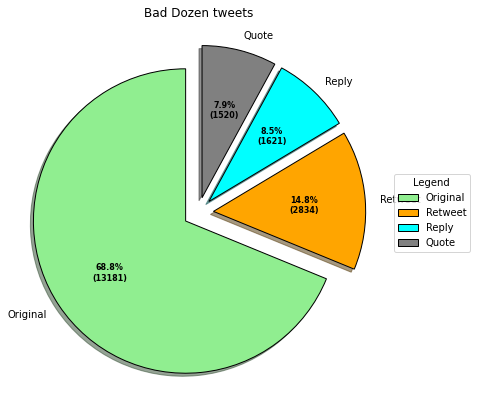

In [7]:
original_bad = df_bad_split["original"]
quote_bad = df_bad_split["quote"]
retweet_bad = df_bad_split["retweet"]
reply_bad = df_bad_split["reply"]
mentions_bad = df_bad_split["original_mention"]
reply_status_bad = df_bad_split['reply_to_status']
retweet_original_bad = df_bad_split['rt_original']
retweet_reply_bad = df_bad_split['rt_in_reply']
retweet_mention_bad = df_bad_split['rt_mention']
quote_original_bad = df_bad_split['quote_original']
quote_reply_bad = df_bad_split['quote_reply']
quote_mention_bad = df_bad_split['quote_mention']
total_len_bad = len(df_bad_activity) 
len_quote_bad = len(quote_bad)
len_original_bad = len(original_bad)
len_rt_bad = len(retweet_bad)
len_rp_bad = len(reply_bad)
len_mentions_bad = len(mentions_bad)
len_reply_status_bad = len(reply_status_bad)
len_retweet_original_bad = len(retweet_original_bad)
len_retweet_reply_bad = len(retweet_reply_bad)
len_retweet_mention_bad = len(retweet_mention_bad)
len_quote_original_bad = len(quote_original_bad)
len_quote_reply_bad = len(quote_reply_bad)
len_quote_mention_bad = len(quote_mention_bad)
tweets_utils.stats(total_len_bad, len_original_bad, len_rt_bad, len_rp_bad, len_quote_bad)
tweets_utils.print_pie_chart4("Bad Dozen tweets", "Original", "Retweet", "Reply", "Quote", len_original_bad, len_rt_bad, len_rp_bad, len_quote_bad)

Number of total tweets: 750820
Number of original tweets: 146304
Number of retweets: 287203
Number of replies: 233374
Number of quotes: 83939
Number of original_tweets: 19.49% of total tweets
Number of retweets: 38.25% of total tweets
Number of replies: 31.08% of total tweets
Number of quotes: 11.18% of total tweets
Check sum == len(tweets):  True


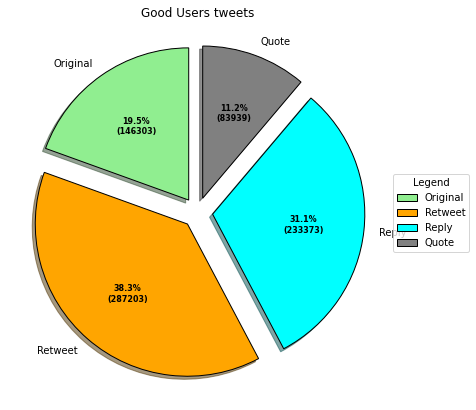

In [8]:
original_good = df_good_split["original"]
quote_good = df_good_split["quote"]
retweet_good = df_good_split["retweet"]
reply_good = df_good_split["reply"]
mentions_good = df_good_split["original_mention"]
reply_status_good = df_good_split['reply_to_status']
retweet_original_good = df_good_split['rt_original']
retweet_reply_good = df_good_split['rt_in_reply']
retweet_mention_good = df_good_split['rt_mention']
quote_original_good = df_good_split['quote_original']
quote_reply_good = df_good_split['quote_reply']
quote_mention_good = df_good_split['quote_mention']
total_len_good = len(df_good_activity) 
len_quote_good = len(quote_good)
len_original_good = len(original_good)
len_rt_good = len(retweet_good)
len_rp_good = len(reply_good)
len_mentions_good = len(mentions_good)
len_reply_status_good = len(reply_status_good)
len_retweet_original_good = len(retweet_original_good)
len_retweet_reply_good = len(retweet_reply_good)
len_retweet_mention_good = len(retweet_mention_good)
len_quote_original_good = len(quote_original_good)
len_quote_reply_good = len(quote_reply_good)
len_quote_mention_good = len(quote_mention_good)
tweets_utils.stats(total_len_good, len_original_good, len_rt_good, len_rp_good, len_quote_good)
tweets_utils.print_pie_chart4("Good Users tweets", "Original", "Retweet", "Reply", "Quote", len_original_good, len_rt_good, len_rp_good, len_quote_good)

# Stats
<a id="c_stats"/>

In [99]:
bad_values = [(len_original_bad/total_len_bad), (len_rt_bad/total_len_bad), (len_rp_bad/total_len_bad), (len_quote_bad/total_len_bad)]
good_values = [len_original_good/total_len_good, len_rt_good/total_len_good, len_rp_good/total_len_good, len_quote_good/total_len_good]
labels = ["Original", "Retweet", "Reply", "Quote"]

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="sum", y=bad_values, x=labels, name="Bad"))
fig.add_trace(go.Histogram(histfunc="sum", y=good_values, x=labels, name="Good"))
fig.update_layout(
    title="Differences between Bad Dozen and Good Users activity",
    xaxis_title="Kind of activity",
    yaxis_title="Percentage of activity",
    legend_title="Legend")
fig.show()


# Original
<a id="original"/>

In [10]:
diff = len_original_bad - len_mentions_bad
bad_values = [(diff/len_original_bad), (len_mentions_bad/len_original_bad)]
diff = len_original_good - len_mentions_good
good_values = [(diff/len_original_good), (len_mentions_good/len_original_good)]
labels = ["Original posts", "Original with mentsions"]

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="sum", y=bad_values, x=labels, name="Bad"))
fig.add_trace(go.Histogram(histfunc="sum", y=good_values, x=labels, name="Good"))
fig.update_layout(
    title="Differences between Bad Dozen and Good Users activity in original posts",
    xaxis_title="Kind of original posts",
    yaxis_title="Percentage of activity",
    legend_title="Legend")
fig.show()


# Quote
<a id="quote"/>

In [11]:
bad_values = [(len_quote_original_bad/len_quote_bad), (len_quote_reply_bad/len_quote_bad), (len_quote_mention_bad/len_quote_bad)]
good_values = [(len_quote_original_good/len_quote_good), (len_quote_reply_good/len_quote_good), (len_quote_mention_good/len_quote_good)]
labels = ["Quotes to originals", "Quotes to replies", "Quotes to mentions",]

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="sum", y=bad_values, x=labels, name="Bad"))
fig.add_trace(go.Histogram(histfunc="sum", y=good_values, x=labels, name="Good"))
fig.update_layout(
    title="Differences between Bad Dozen and Good Users activity in Quotes",
    xaxis_title="Kind of Quote",
    yaxis_title="Percentage of activity",
    legend_title="Legend")
fig.show()


# Retweet
<a id="rt"/>

In [12]:
# val = pd.Series(df_bad_dozen_interactions["rt_user_screen_name"])
# val = val.value_counts().sort_values(ascending=False)
# fig = plt.figure(figsize=(14, 8))
# ax = val[:10].plot(kind='barh', color='lightseagreen', fig=(14,14)) #green #steelblue
# ax.set_title('Top 10 RETWEETED BAD DOZEN', fontsize=15)
# ax.invert_yaxis()
# plt.show()

# val = pd.Series(df_good_users_interactions["rt_user_screen_name"])
# val = val.value_counts().sort_values(ascending=False)
# fig = plt.figure(figsize=(14, 8))
# ax = val[:10].plot(kind='barh', color='green', fig=(14,14)) #green #steelblue
# ax.set_title('Top 10 RETWEETED GOOD DOZEN', fontsize=15)
# ax.invert_yaxis()
# plt.show()

In [13]:
bad_values = [(len_retweet_original_bad/len_rt_bad), (len_retweet_reply_bad/len_rt_bad), (len_retweet_mention_bad/len_rt_bad)]
good_values = [(len_retweet_original_good/len_rt_good), (len_retweet_reply_good/len_rt_good), (len_retweet_mention_good/len_rt_good)]
labels = ["Retweet of original", "Retweet of reply", "Retweet of mention",]

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="sum", y=bad_values, x=labels, name="Bad"))
fig.add_trace(go.Histogram(histfunc="sum", y=good_values, x=labels, name="Good"))
fig.update_layout(
    title="Differences between Bad Dozen and Good Users activity in Retweet",
    xaxis_title="Kind of Retweet",
    yaxis_title="Percentage of activity",
    legend_title="Legend")
fig.show()


# Most Shared Tweets
<a id="mst"/>

In [16]:
original_bad_most_shared = original_bad[original_bad["retweet_count"].notna()].sort_values(by=["retweet_count"], ascending=False)[["id",
              "created_at", "user_id", "user_screen_name", "text", "retweet_count"]][:16]
original_bad_most_shared = original_bad_most_shared[original_bad_most_shared["user_screen_name"]=="RobertKennedyJr"]
original_bad_most_shared

,id,created_at,user_id,user_screen_name,text,retweet_count
3938,1299439789742198785,2020-08-28 20:12:42+00:00,337808606.0,RobertKennedyJr,In #Berlin launching @ChildrensHD Europe. Tomo...,7155.0
3696,1352748139665645569,2021-01-22 22:41:03+00:00,337808606.0,RobertKennedyJr,#HankAaron's tragic death is part of a wave of...,7140.0
4047,1284163629240119296,2020-07-17 16:30:42+00:00,337808606.0,RobertKennedyJr,Remembering my beloved cousin John. November 2...,4685.0
4110,1272946392210771968,2020-06-16 17:37:24+00:00,337808606.0,RobertKennedyJr,"Finally, the case against chemical water fluor...",4336.0
3441,1395404944925249536,2021-05-20 15:43:58+00:00,337808606.0,RobertKennedyJr,"Under federal law, employers + universities ca...",4234.0
4268,1248747718295633921,2020-04-10 23:00:31+00:00,337808606.0,RobertKennedyJr,Public health advocates around the world accus...,3961.0
3289,1412792969996947456,2021-07-07 15:17:47+00:00,337808606.0,RobertKennedyJr,"The teen’s father, Fabio Berlingieri, said his...",3899.0
3656,1362150453610483713,2021-02-17 21:22:30+00:00,337808606.0,RobertKennedyJr,#Gates continues to move the goalposts. Meanwh...,3604.0
3270,1417915320392691713,2021-07-21 18:32:10+00:00,337808606.0,RobertKennedyJr,America’s Frontline Doctors filed a motion to ...,3586.0
3665,1359980714012327936,2021-02-11 21:40:44+00:00,337808606.0,RobertKennedyJr,READ + RT my response to #Instagram's deplatfo...,3562.0


In [17]:
original_bad_most_shared["retweet_count"].sum()

62450.0

In [30]:
# original_good[original_good["retweet_count"].notna()].sort_values(by=["retweet_count"], ascending=False)[["id",
#               "created_at", "user_id", "user_screen_name", "text", "retweet_count"]][:15]

# Link shared by Dozen
<a id="link_sh"/>

In [272]:
val = ["[]", 2,3,4,5,6]
val = [i for i in val if i != "[]"]
val

[2, 3, 4, 5, 6]

In [7]:
importlib.reload(tweets_utils)
def substitute_compressed_url(df, flag = False, fbme = None, expanded_urls = expanded_urls):
    df_urls = df.loc[df['urls'] != '[]']
    df_urls = df.loc[df['urls'].notna()]
    urls = df_urls["urls"]
    val = []
    for i in urls:
        if type(i) == float:
            print(i)
        else:
            val.append(i)
    val = [i for i in val if i != "[]"]
    print(len(val))
#     for i in val:
#         print(i)
#         print(type(i))
#         print(i.split()[3])
    val = [x.split()[3].translate({ord("'"): None}).replace(",","") for x in val]
    df_urls = pd.DataFrame(val, columns=["urls"])
    df_merge = df_urls.merge(expanded_urls, how="left", left_on="urls", right_on="url")
    x = df_merge[df_merge["url"].notna()]
    if flag:
        y = df_urls.merge(fbme, left_on="urls", right_on="compressed", how="left")
        y = y[y["compressed"].notna()]
        for index, row in tqdm(y.iterrows()):
            df_urls.loc[df_urls["urls"]==row["compressed"], "urls"] = row["decompressed"]
    print(len(x))
    for index, row in tqdm(x.iterrows()):
        df_urls.loc[df_urls["urls"]==row["url"], "urls"] = row["expanded"]
    print("Beautify...")
    urls = df_urls["urls"]
    urls = [tweets_utils.url_decompress(v) for v in urls]
    urls = tweets_utils.remove_www(urls)
    return urls

In [280]:
df_good_activity_urls = substitute_compressed_url(df_good_activity)
df_bad_activity_urls = substitute_compressed_url(df_bad_activity, True, bad_fbme)

In [139]:
df_good_urls = pd.DataFrame(df_good_activity_urls, columns =['Url'])
bad_urls = pd.Series(df_bad_activity_urls).value_counts().sort_values(ascending=False)
x = df_good_urls[df_good_urls["Url"].isin(list(bad_urls[1:17].keys()))]
good_urls = pd.Series(x["Url"]).value_counts().sort_values(ascending=False)
ind = []
type_b = []
type_g = []
for i in bad_urls[1:17].keys():
    type_g.append("Good")
    type_b.append("Bad")
    if i in good_urls:
        continue
    else:
        good_urls = good_urls.append(pd.Series(0,index=[i]))
good_urls_values = list(good_urls.values)
good_urls_keys = list(good_urls.keys())
bad_urls_values = list(bad_urls[1:17].values)
bad_urls_keys = list(bad_urls[1:17].keys())
df_plot_good = pd.DataFrame(zip(good_urls_values, good_urls_keys, type_g), columns=["Val", "Url", "Dozen"])
df_plot_bad = pd.DataFrame(zip(bad_urls_values, bad_urls_keys, type_b), columns=["Val", "Url", "Dozen"])
df_plot = df_plot_good.append(df_plot_bad)
df_plot = df_plot.reset_index(drop = True)

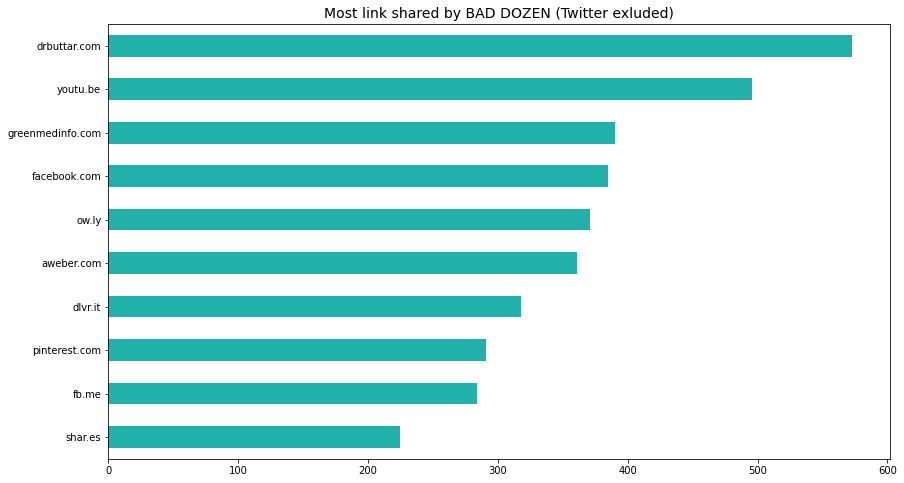

In [83]:
val = pd.Series(df_bad_activity_urls).value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[1:11].plot(kind='barh', color='lightseagreen', fig=(14,14))
ax.set_title('Most link shared by BAD DOZEN (Twitter exluded)', fontsize=14)
ax.invert_yaxis()
plt.show()

In [84]:
# df_urls = df_bad_activity.loc[df_bad_activity['urls'] != '[]']
# df_urls = [x.split()[3].translate({ord("'"): None}).replace(",","") for x in df_urls["urls"]]
# df_urls = [x if ("https://youtu.be" in x) or ("https://www.youtube.com" in x) else np.nan for x in df_urls]
# df_urls = list(pd.Series(df_urls).dropna())
# # df_urls.value_counts().sort_values(ascending=False)
# importlib.reload(tweets_utils)
# df_urls_yt = tweets_utils.check_availability(df_urls)

In [71]:
# df_urls_yt.to_csv("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/csv/urls_yt.csv",
#                  line_terminator="\n", index=False, encoding="utf-8")

In [140]:
value_good = df_plot.loc[6]["Val"] + df_plot.loc[8]["Val"]
value_bad = df_plot.loc[16]["Val"] + df_plot.loc[25]["Val"]
df_plot.loc[df_plot.index == 6, 'Val'] = value_good
df_plot.loc[df_plot.index == 25, 'Val'] = value_bad
a = ["bit.ly", "shar.es", "ow.ly", "dlvr.it", "ift.tt", "fb.me"]
df_plot = df_plot[~df_plot["Url"].isin(a)]

In [147]:
df_plot = df_plot.sort_values(["Dozen", "Val"])
lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
df_plot["classifica"] = lst
df_plot = df_plot.sort_values("classifica", ascending=False)
df_plot

,Val,Url,Dozen,classifica
16,573,drbuttar.com,Bad,10
17,496,youtu.be,Bad,9
18,390,greenmedinfo.com,Bad,8
19,385,facebook.com,Bad,7
21,361,aweber.com,Bad,6
23,291,pinterest.com,Bad,5
26,213,medicalrewind.com,Bad,4
27,165,instagram.com,Bad,3
29,133,ecowatch.com,Bad,2
31,96,childrenshealthdefense.org,Bad,1


In [148]:
fig = px.bar(df_plot, x="Val", y="Url", color="Dozen", barmode='group', title="Top 10 Bad Dozen domain shared (with comparison)")
fig.update_layout(
    font_size = 15,
    yaxis = dict(autorange="reversed")
)
fig.show()

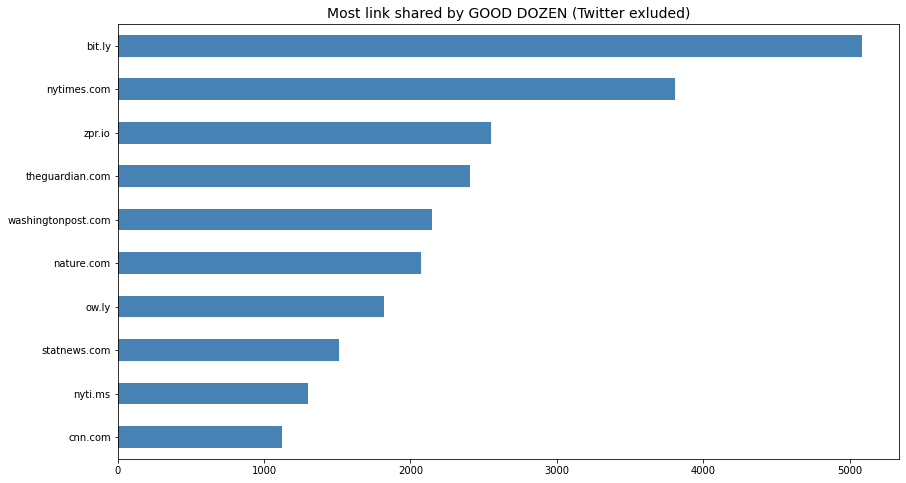

In [149]:
val = pd.Series(df_good_activity_urls).value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[1:11].plot(kind='barh', color='steelblue', fig=(14,14))
ax.set_title('Most link shared by GOOD DOZEN (Twitter exluded)', fontsize=14)
ax.invert_yaxis()
plt.show()

In [150]:
df_bad_urls = pd.DataFrame(df_bad_activity_urls, columns =['Url'])
good_url = pd.Series(df_good_activity_urls).value_counts().sort_values(ascending=False)
x = df_bad_urls[df_bad_urls["Url"].isin(list(good_url[1:15].keys()))]
bad_url = pd.Series(x["Url"]).value_counts().sort_values(ascending=False)
ind = []
type_b = []
type_g = []
for i in good_url[1:15].keys():
    type_g.append("Good")
    type_b.append("Bad")
    if i in bad_url:
        continue
    else:
        bad_url = bad_url.append(pd.Series(0,index=[i]))
bad_url
good_urls_values = list(good_url[1:15].values)
good_urls_keys = list(good_url[1:15].keys())
bad_urls_values = list(bad_url.values)
bad_urls_keys = list(bad_url.keys())
df_plot_good = pd.DataFrame(zip(good_urls_values, good_urls_keys, type_g), columns=["Val", "Url", "Dozen"])
df_plot_bad = pd.DataFrame(zip(bad_urls_values, bad_urls_keys, type_b), columns=["Val", "Url", "Dozen"])
df_plot = df_plot_good.append(df_plot_bad)
df_plot = df_plot.reset_index(drop = True)

In [27]:
# value_good = df_plot.loc[2]["Val"] + df_plot.loc[3]["Val"]
# value_bad = df_plot.loc[17]["Val"] + df_plot.loc[18]["Val"]
# df_plot.loc[df_plot.index == 3, 'Val'] = value_good
# df_plot.loc[df_plot.index == 18, 'Val'] = value_bad
# df_plot

In [152]:
a = ["bit.ly", "shar.es", "ow.ly", "dlvr.it", "ift.tt", "nyti.ms", "zpr.io"]
df_plot = df_plot[~df_plot["Url"].isin(a)]
df_plot = df_plot.sort_values(by="Val", ascending=False)
fig = px.bar(df_plot, x="Val", y="Url", color="Dozen", barmode='group', title="Top 10 Good Dozen domain shared (with comparison)")
fig.update_layout(
        font_size = 15,
    yaxis = dict(autorange="reversed"))
fig.show()

### Youtube Domain
<a id="yt"/>

#### Bad
<a id="bad_yt"/>

In [15]:
# df_urls = df_bad_activity.loc[df_bad_activity['urls'] != '[]']
# val = [x.split()[3].translate({ord("'"): None}).replace(",","") for x in df_urls["urls"]]
# val = [x if ("https://youtu.be" in x) or ("https://www.youtube.com" in x) else np.nan for x in val]
# df_urls["urls"] = val
# df_urls = df_urls[["user_screen_name", "urls"]]
# df_urls = df_urls[df_urls["urls"].notna()]
# df_urls.rename(columns={'urls': 'URL', "user_screen_name": "NAME"}, inplace=True)
# df_urls.to_csv(path_csv[0] + "bad_dozen_yt_urls.csv", line_terminator="\n", 
#               encoding="utf-8", index=False)
yt_df = pd.read_csv("F:/Supsi/COVID-19-Tweets/large_files/urls/yt_bad_parsed.csv", lineterminator="\n")
yt_df

,user_name,title,description,url,type,available,reason
0,BusyDrT,NaN,NaN,https://www.youtube.com/watch?v=hbtDQ73mscg,decompressed,False,Unavailable
1,RobertKennedyJr,NaN,NaN,https://www.youtube.com/watch?v=RzFP4yzZzII&fe...,decompressed,False,Unavailable
2,kevdjenkins1,NaN,NaN,https://youtu.be/sTFOsQfDFi8,compressed,False,Unavailable
3,mercola,MASS PSYCHOSIS - How an Entire Population Beco...,This video was made in collaboration with Acad...,https://www.youtube.com/watch?v=09maaUaRT4M,decompressed,True,Parsed
4,mercola,The Dirty Dozen (1967) - The War Games Scene (...,The Dirty Dozen - The War Games: The Dirty Doz...,https://www.youtube.com/watch?v=W_0FrTMGF9s,decompressed,True,Parsed
...,...,...,...,...,...,...,...
425,kevdjenkins1,The Arc of Justice: Reparations for African Am...,Duke University’s William A. Darity Jr. speaks...,https://youtu.be/s3mSCwOIBjU,compressed,True,Parsed
426,kevdjenkins1,This Will Leave You Speechless! - One of The M...,THIS Will Make You Re-Consider Your Entire Exi...,https://youtu.be/nKd2QVrQVIM,compressed,True,Parsed
427,kevdjenkins1,Sara Bareilles - Goodbye Yellow Brick Road (Li...,Official music video for ”Goodbye Yellow Brick...,https://youtu.be/Ozd2ja7mAgM,compressed,True,Parsed
428,kevdjenkins1,NaN,NaN,https://youtu.be/ZvW3BbLAzZA,compressed,False,Unavailable


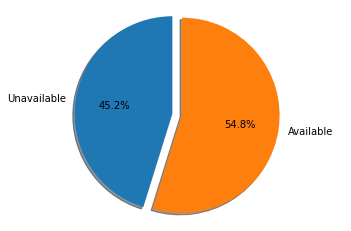

In [19]:
av = len(yt_df[yt_df["reason"]=="Unavailable"])
unav = len(yt_df[yt_df["reason"]=="Parsed"])
labels = 'Unavailable', 'Available'
sizes = [av, unav]
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

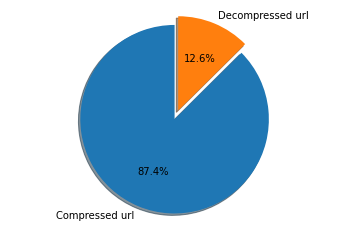

In [20]:
comp = len(yt_df[yt_df["type"]=="compressed"])
decomp = len(yt_df[yt_df["type"]=="decompressed"])

labels = 'Compressed url', 'Decompressed url'
sizes = [comp, decomp]
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

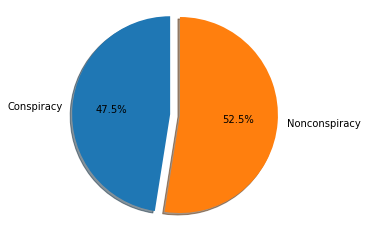

In [115]:
yt = yt_df[yt_df["conspiracy"].notna()]
consp = len(yt[yt["conspiracy"]==True])
noconsp = len(yt[yt["conspiracy"]==False])

labels = 'Conspiracy', 'Nonconspiracy'
sizes = [consp, noconsp]
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

#### Good
<a id="good_yt"/>

In [21]:
# df_urls = df_good_activity.loc[df_good_activity['urls'] != '[]']
# val = [x.split()[3].translate({ord("'"): None}).replace(",","") for x in df_urls["urls"]]
# val = [x if ("https://youtu.be" in x) or ("https://www.youtube.com" in x) else np.nan for x in val]
# df_urls["urls"] = val
# df_urls = df_urls[["user_screen_name", "urls"]]
# df_urls = df_urls[df_urls["urls"].notna()]
# df_urls.rename(columns={'urls': 'URL', "user_screen_name": "NAME"}, inplace=True)
# df_urls.to_csv(path_csv[0] + "good_dozen_yt_urls.csv", line_terminator="\n", 
#               encoding="utf-8", index=False)

In [23]:
path_urls = glob.glob("F:/Supsi/COVID-19-Tweets/large_files/urls/")
yt_df = pd.read_csv(path_urls[0] + "yt_good_parsed.csv", lineterminator="\n")
yt_df

,user_name,title,description,url,type,available,reason
0,JeremyKonyndyk,Feast On The Goo,NaN,https://www.youtube.com/watch?v=RzybAS7zltE,decompressed,True,Parsed
1,PeterDaszak,Wildlife and the virus - The Wuhan wake-up cal...,The coronavirus outbreak is not the first to j...,https://youtu.be/Iwr5rpgLa5s,compressed,True,Parsed
2,BogochIsaac,New coronavirus: 'Masks don't protect you … al...,Infectious disease specialist Dr. Isaac Bogoch...,https://youtu.be/e1B1jPGbamU,compressed,True,Parsed
3,PergamIC,国家卫健委：病毒潜伏期10天左右 最短1天最长14天,订阅频道，获取更多精彩：https://bit.ly/2GzuCVG\n\n1月26日，国家...,https://www.youtube.com/watch?v=PO7PuoHi5cw,decompressed,True,Parsed
4,SaadOmer3,Coronavirus Wuhan residents shout from windows...,Wuhan is the centre of a deadly coronavirus ou...,https://youtu.be/khEcZ7EmUk8,compressed,True,Parsed
...,...,...,...,...,...,...,...
1081,arimoin,fait la différence,Alors que le bilan des victimes du Covid-19 ne...,https://youtu.be/PzwB17jhHBM,compressed,True,Parsed
1082,arimoin,SoCal Connected: Virus Hunter,She's called the unstoppable woman. Meet one o...,https://youtu.be/12XKh37fmgE,compressed,True,Parsed
1083,arimoin,Millennium Falcon or Starship Enterprise? - Fa...,There is no question as to which space vehicle...,https://www.youtube.com/watch?v=TMH1vDDd1xc&sn...,decompressed,True,Parsed
1084,arimoin,Inside the clinic treating the biggest ever Eb...,A unique report from inside the 'chilling' cli...,https://www.youtube.com/watch?v=Th19_Hk2zSg,decompressed,True,Parsed


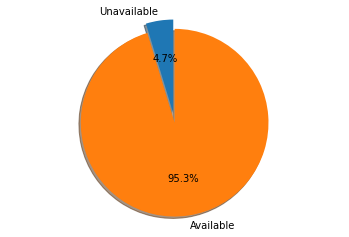

In [24]:
av = len(yt_df[yt_df["reason"]=="Unavailable"])
unav = len(yt_df[yt_df["reason"]=="Parsed"])
labels = 'Unavailable', 'Available'
sizes = [av, unav]
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

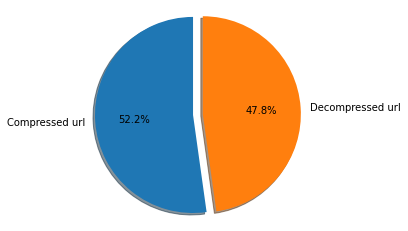

In [25]:
comp = len(yt_df[yt_df["type"]=="compressed"])
decomp = len(yt_df[yt_df["type"]=="decompressed"])

labels = 'Compressed url', 'Decompressed url'
sizes = [comp, decomp]
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

#### SAGE on description
<a id="sage_yt"/>

In [31]:
sage_description = pd.read_csv("F:/Supsi/COVID-19-Tweets/large_files/sage_data/yt_description_sage.csv",
                              lineterminator="\n", low_memory=False)
sage_description

,source,word,sage,file_count,file_rate,base_count,base_rate
0,.\data\bad_yt_descriptions.txt,amend,1.952158,27,0.001510,27,0.000323
1,.\data\bad_yt_descriptions.txt,dore,1.947712,25,0.001398,25,0.000299
2,.\data\bad_yt_descriptions.txt,fox,1.912785,56,0.003131,60,0.000718
3,.\data\bad_yt_descriptions.txt,cable,1.907644,15,0.000839,15,0.000180
4,.\data\bad_yt_descriptions.txt,fnc,1.907644,15,0.000839,15,0.000180
5,.\data\bad_yt_descriptions.txt,valuetainment,1.882488,12,0.000671,12,0.000144
6,.\data\bad_yt_descriptions.txt,awakening,1.882488,12,0.000671,12,0.000144
7,.\data\bad_yt_descriptions.txt,sears,1.882488,12,0.000671,12,0.000144
8,.\data\bad_yt_descriptions.txt,nrule,1.882488,12,0.000671,12,0.000144
9,.\data\bad_yt_descriptions.txt,censorship,1.882488,12,0.000671,12,0.000144


In [32]:
sage_title = pd.read_csv("F:/Supsi/COVID-19-Tweets/large_files/sage_data/yt_title_sage.csv",
                              lineterminator="\n", low_memory=False)
sage_title

,source,word,sage,file_count,file_rate,base_count,base_rate
0,.\data\bad_yt_titles.txt,right,1.910087,7,0.005132,8,0.001056
1,.\data\bad_yt_titles.txt,told,1.872861,4,0.002933,4,0.000528
2,.\data\bad_yt_titles.txt,byron,1.872861,4,0.002933,4,0.000528
3,.\data\bad_yt_titles.txt,reparations,1.872861,4,0.002933,4,0.000528
4,.\data\bad_yt_titles.txt,truth,1.857430,6,0.004399,7,0.000924
5,.\data\bad_yt_titles.txt,agenda,1.783770,5,0.003666,6,0.000792
6,.\data\bad_yt_titles.txt,election,1.739247,3,0.002199,3,0.000396
7,.\data\bad_yt_titles.txt,americans,1.739247,3,0.002199,3,0.000396
8,.\data\bad_yt_titles.txt,pleiadian,1.739247,3,0.002199,3,0.000396
9,.\data\bad_yt_titles.txt,heated,1.739247,3,0.002199,3,0.000396


### Facebook
<a id="fb"/>

In [18]:
df_urls = df_bad_activity.loc[df_bad_activity['urls'] != '[]']
val = [x.split()[3].translate({ord("'"): None}).replace(",","") for x in df_urls["urls"]]
val = [x if ("fb.me" in x) else np.nan for x in val]
df_urls["urls"] = val
df_urls = df_urls[["user_screen_name", "urls"]]
df_urls = df_urls[df_urls["urls"].notna()]
df_urls.rename(columns={'urls': 'URL', "user_screen_name": "NAME"}, inplace=True)
# df_urls.to_csv(path_csv[0] + "good_dozen_fbme_urls.csv", line_terminator="\n", 
#               encoding="utf-8", index=False)
df_urls

,NAME,URL
7392,DrButtar,https://fb.me/EPu9rjHn
7393,DrButtar,https://fb.me/1mUr3gt4x
7395,DrButtar,https://fb.me/1eep4j7mN
7396,DrButtar,https://fb.me/Wf6zAxuP
7397,DrButtar,https://fb.me/73oNm7K6U
...,...,...
20181,DrChrisNorthrup,http://fb.me/AYDEWSEs
20182,DrChrisNorthrup,http://fb.me/8EGZtraE3
20183,DrChrisNorthrup,http://fb.me/86C90eEHJ
20184,DrChrisNorthrup,http://fb.me/6zI2rsAzH


# Hashtags
<a id="comp_hashtag"/>

In [225]:
from datetime import date
def get_series(hash_date, name):
    d = hash_date[hash_date["hashtag"]==name]["date"]
    dates_list = []
    for i in list(d):
        x = i.split()[0]
        if not "2" in x:
            x = tweets_utils.process_datetime(i)        
        dates_list.append(datetime.strptime(x, '%Y-%m-%d'))
    serie = pd.Series(dates_list, name=name).value_counts().sort_index()
    return serie

In [226]:
def plot_lines(hashtags):
    x1 = get_series(hash_date, hashtags[0])
    x2 = get_series(hash_date, hashtags[1])
    x3 = get_series(hash_date, hashtags[2])
    x4 = get_series(hash_date, hashtags[3])
    x5 = get_series(hash_date, hashtags[4])
    df = pd.concat([x1, x2, x3, x4, x5], axis=1)
    df = df.fillna(0)
    df.sort_index(ascending=True, inplace=True)
    lines = df.plot.line(figsize=(14,6))
    lines.set_xlim([date(2020, 1, 1), date(2021, 9, 1)])

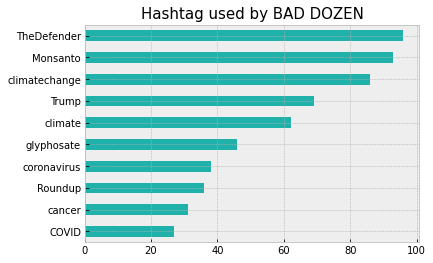

In [221]:
val = pd.Series(tweets_utils.hashtag_process(df_bad_activity))
val = val.value_counts().sort_values(ascending=False)
fig = plt.figure()
ax = val[:10].plot(kind='barh', color='lightseagreen') #red #darkturquoise
ax.set_title('Hashtag used by BAD DOZEN', fontsize=15)
ax.invert_yaxis()
plt.show()

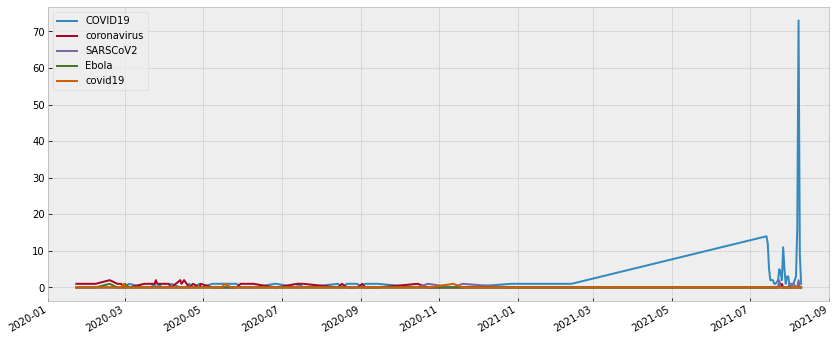

In [241]:
importlib.reload(tweets_utils)
df_bad_hashtags = df_bad_dozen_interactions[["created_at", "hashtags"]]
df_bad_hashtags = df_bad_hashtags[df_bad_hashtags["hashtags"]!="[]"]
hash_date = tweets_utils.hashtag_date(df_bad_hashtags)
hashtags = list(val[:5].index)
plot_lines(hashtags)

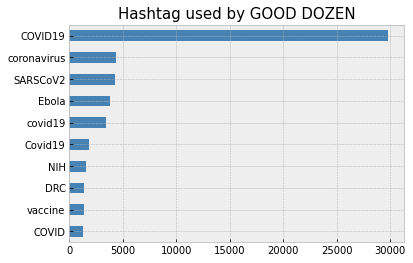

In [223]:
val = pd.Series(tweets_utils.hashtag_process(df_good_activity))
val = val.value_counts().sort_values(ascending=False)
fig = plt.figure()
ax = val[:10].plot(kind='barh', color='steelblue') #red #darkturquoise
ax.set_title('Hashtag used by GOOD DOZEN', fontsize=15)
ax.invert_yaxis()
plt.show()

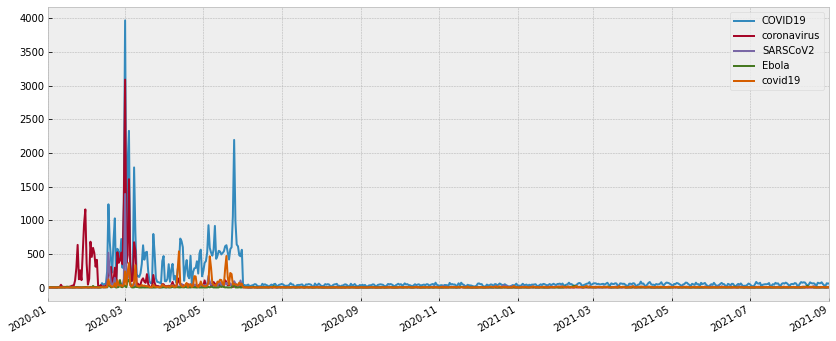

In [227]:
importlib.reload(tweets_utils)
df_good_hashtags = df_good_users_interactions[["created_at", "hashtags"]]
df_good_hashtags= df_good_hashtags[df_good_hashtags["hashtags"]!="[]"]
hash_date = tweets_utils.hashtag_date(df_good_hashtags)
hashtags = list(val[:5].index)
plot_lines(hashtags)

# Dozen Followers RT
<a id="follow"/>

## Domains
<a id="dm"/>

In [10]:
df_good_activity_urls = substitute_compressed_url(good_rt_in)
df_bad_activity_urls = substitute_compressed_url(bad_rt_in, True, bad_fbme)

180714
190


0it [00:00, ?it/s]

Beautify...
invalid data
125810


0it [00:00, ?it/s]

116


0it [00:00, ?it/s]

Beautify...


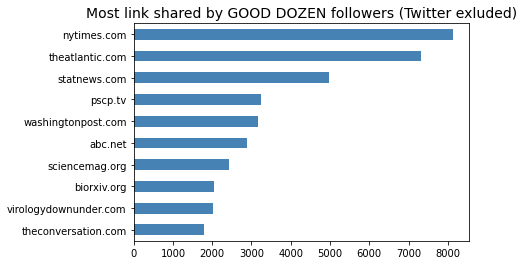

In [12]:
val = pd.Series(df_good_activity_urls).value_counts().sort_values(ascending=False)
fig = plt.figure()
ax = val[1:11].plot(kind='barh', color='steelblue')
ax.set_title('Most link shared by GOOD DOZEN followers (Twitter exluded)', fontsize=14)
ax.invert_yaxis()
plt.show()

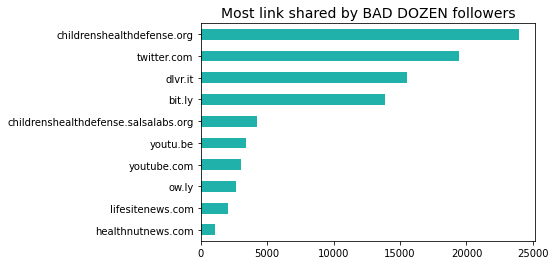

In [13]:
val = pd.Series(df_bad_activity_urls).value_counts().sort_values(ascending=False)
fig = plt.figure()
ax = val[0:10].plot(kind='barh', color='lightseagreen')
ax.set_title('Most link shared by BAD DOZEN followers', fontsize=14)
ax.invert_yaxis()
plt.show()

# Hashtags
<a id="hs"/>

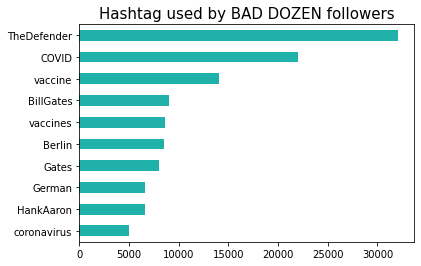

In [16]:
val = pd.Series(tweets_utils.hashtag_process(bad_rt_in))
val = val.value_counts().sort_values(ascending=False)
fig = plt.figure()
ax = val[:10].plot(kind='barh', color='lightseagreen') #red #darkturquoise
ax.set_title('Hashtag used by BAD DOZEN followers', fontsize=15)
ax.invert_yaxis()
plt.show()

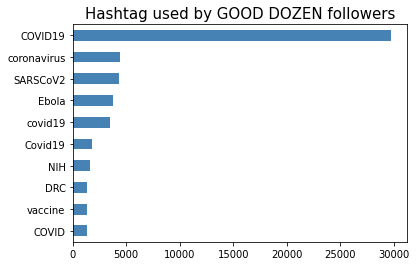

In [17]:
val = pd.Series(tweets_utils.hashtag_process(df_good_activity))
val = val.value_counts().sort_values(ascending=False)
fig = plt.figure()
ax = val[:10].plot(kind='barh', color='steelblue') #red #darkturquoise
ax.set_title('Hashtag used by GOOD DOZEN followers', fontsize=15)
ax.invert_yaxis()
plt.show()

# Credibility comparison
<a id="cred_comp"/>

In [228]:
scores = pd.read_csv(path[0] + "sum_of_urls_df_all_months_with_score.csv", low_memory=False, lineterminator="\n")
scores = scores[scores["conspiracy_score"].notna()]
scores = scores[scores["number_of_urls"]>=10]
scores = scores.reset_index(drop=True)

In [229]:
path_rt = glob.glob("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/to_be_scored/")[0]
good_rt = pd.read_csv(path_rt + "good_rt.csv", lineterminator="\n")
bad_rt = pd.read_csv(path_rt + "bad_rt.csv", lineterminator="\n")

In [230]:
title = []
for i in range(len(good_rt["user_screen_name"])):
    title.append("good")
good_rt["dozen"]=title
good_rt
title = []
for i in range(len(bad_rt["user_screen_name"])):
    title.append("bad")
bad_rt["dozen"]=title
bad_rt

,user_screen_name,dozen
0,IFilonczuk,bad
1,ajividen73,bad
2,quingem,bad
3,Sorothavy,bad
4,GiancanaSonny,bad
...,...,...
149222,MorrisJanie,bad
149223,Schypha,bad
149224,chadlipscomb2,bad
149225,Micki82538979,bad


In [231]:
scores_merged_good = scores.merge(good_rt, left_on='user_screen_name', right_on='user_screen_name', how="left")
scores_merged_final = scores_merged_good.merge(bad_rt, left_on='user_screen_name', right_on='user_screen_name', how="left")
scores_merged_final

,user_screen_name,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,dozen_x,dozen_y
0,KeiserOla,12.0,0.0,1.0,9.0,2.0,1.0,NaN,NaN
1,Breinbrouwsels,25.0,0.0,2.0,19.0,4.0,1.0,NaN,NaN
2,PABurch,12.0,0.0,1.0,1.0,10.0,1.0,NaN,NaN
3,CristianeWynnie,12.0,0.0,1.0,11.0,0.0,1.0,NaN,NaN
4,ak2webd3,12.0,0.0,1.0,9.0,2.0,1.0,good,NaN
...,...,...,...,...,...,...,...,...,...
144443,Gus_802,15.0,2.0,0.0,3.0,10.0,0.0,NaN,NaN
144444,FemiJelena,15.0,3.0,0.0,7.0,5.0,0.0,NaN,bad
144445,tunde_adenuga,15.0,3.0,0.0,10.0,2.0,0.0,NaN,NaN
144446,Teensthack,15.0,2.0,0.0,10.0,3.0,0.0,NaN,NaN


In [242]:
lst = []
for i in range(len(scores_merged_final["dozen_x"])):
#     if pd.isna(scores_merged_final["dozen_x"][i]) & (pd.isna(scores_merged_final["dozen_y"][i])):
#         lst.append("common")
    if pd.isna(scores_merged_final["dozen_x"][i]) & (scores_merged_final["dozen_y"][i] == "bad"):
        lst.append("bad")
    elif (scores_merged_final["dozen_x"][i] == "good") & (pd.isna(scores_merged_final["dozen_y"][i])):
        lst.append("good")
#     elif (scores_merged_final["dozen_x"][i] == "good") & (scores_merged_final["dozen_y"][i] == "bad"):
#         lst.append("same")
    else:
        lst.append(np.nan)

In [243]:
scores_dozen = scores
scores_dozen["dozen"]=lst
scores_dozen = scores_dozen[scores_dozen["dozen"].notna()].reset_index(drop=True)
pd.Series(scores_dozen["dozen"]).value_counts().sort_values(ascending=False)

bad     10153
good     7145
Name: dozen, dtype: int64

In [252]:
fig = px.box(scores_dozen, x="conspiracy_score", color="dozen", title="Conspiracy score box plot", 
                            labels={
                            "dozen" : "Kind of user",
                            "conspiracy_score" : "Score from 0 to 1"
                            },
             color_discrete_sequence=["red", "blue"]
                            )
fig.show()

In [236]:
data_to_plot = [list(scores_dozen[scores_dozen["dozen"]=="common"]["conspiracy_score"]),
                list(scores_dozen[scores_dozen["dozen"]=="bad"]["conspiracy_score"]), 
                list(scores_dozen[scores_dozen["dozen"]=="good"]["conspiracy_score"]),
                list(scores_dozen[scores_dozen["dozen"]=="same"]["conspiracy_score"])]

df = pd.DataFrame(list(zip(data_to_plot[0], data_to_plot[1],data_to_plot[2],data_to_plot[3])), columns=["a","b","c","d"])
# df

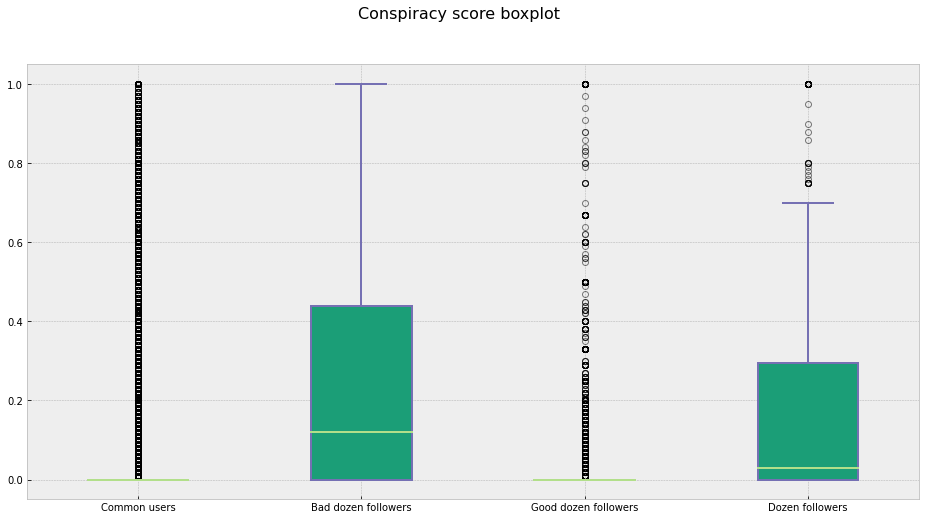

In [237]:
import matplotlib.ticker as ticker
fig = plt.figure(1, figsize=(16, 8))
fig.suptitle('Conspiracy score boxplot', fontsize=16)
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot, sym='')
## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='grey', alpha=0.5)

ax.xaxis.set_major_locator(ticker.FixedLocator([1,2,3,4]))
ax.set_xticklabels(['Common users', 'Bad dozen followers', 'Good dozen followers', 'Dozen followers'])
fig.show()

In [159]:
bad_score = scores[scores["user_screen_name"].isin(list(bad_rt["user_screen_name"]))]

In [160]:
good_score = scores[scores["user_screen_name"].isin(list(good_rt["user_screen_name"]))]

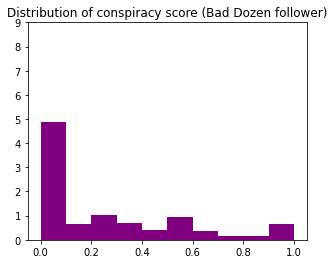

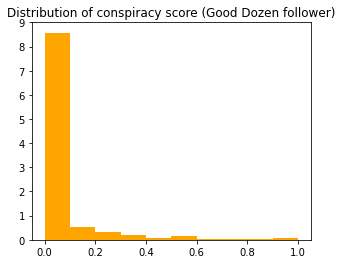

In [164]:
# # Plotting
plt.rcParams["figure.figsize"] = (5,4)

plt.hist(bad_score["conspiracy_score"], 10, color="purple", density=True, stacked=True)
plt.title("Distribution of conspiracy score (Bad Dozen follower)")
plt.ylim([0, 9])
# plt.yscale('log', nonposy='clip')
plt.show()
plt.hist(good_score["conspiracy_score"], 10, color="orange", density=True, stacked=True)
plt.title("Distribution of conspiracy score (Good Dozen follower)")
plt.ylim([0, 9])

# plt.yscale('log', nonposy='clip')
plt.show()

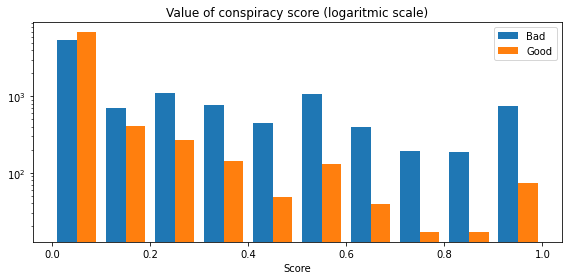

In [48]:
plt.hist([bad_score["conspiracy_score"], good_score["conspiracy_score"]], label=['Bad', 'Good'])
plt.legend(loc='upper right')
plt.title("Value of conspiracy score (logaritmic scale)")
plt.yscale('log', nonposy='clip')
plt.xlabel("Score")
plt.rcParams["figure.figsize"] = (2,1)
plt.show()

# Novax Score
<a id="nova"/>

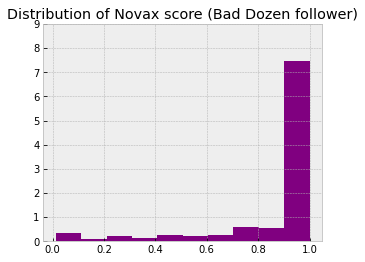

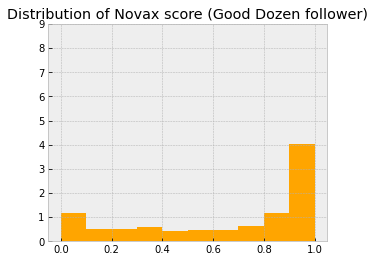

In [238]:
path_score_avaxtar = glob.glob("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/csv/score_avaxtar/")[0]
good_avaxtar = pd.read_csv(path_score_avaxtar + "good_rt_active.csv", lineterminator="\n")
bad_avaxtar = pd.read_csv(path_score_avaxtar + "bad_rt_active.csv", lineterminator="\n")
bad_avaxtar = bad_avaxtar.drop(bad_avaxtar[bad_avaxtar.score == "Error"].index)
good_avaxtar = good_avaxtar.drop(good_avaxtar[good_avaxtar.score == "Error"].index)
bad_avaxtar["score"] = bad_avaxtar["score"].astype("float")
good_avaxtar["score"] = good_avaxtar["score"].astype("float")
# # Plotting
plt.rcParams["figure.figsize"] = (5,4)

plt.hist(bad_avaxtar["score"], 10, color="purple", density=True, stacked=True)
plt.title("Distribution of Novax score (Bad Dozen follower)")
plt.ylim([0, 9])
# plt.yscale('log', nonposy='clip')
plt.show()
plt.hist(good_avaxtar["score"], 10, color="orange", density=True, stacked=True)
plt.title("Distribution of Novax score (Good Dozen follower)")
# plt.yscale('log', nonposy='clip')
plt.ylim([0, 9])

plt.show()

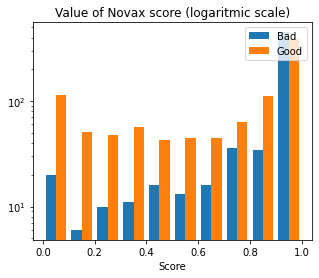

In [32]:
plt.hist([bad_avaxtar["score"], good_avaxtar["score"]], label=['Bad', 'Good'])
plt.legend(loc='upper right')
plt.rcParams["figure.figsize"] = (13,8)
plt.title("Value of Novax score (logaritmic scale)")
plt.yscale('log', nonposy='clip')
plt.xlabel("Score")
plt.show()

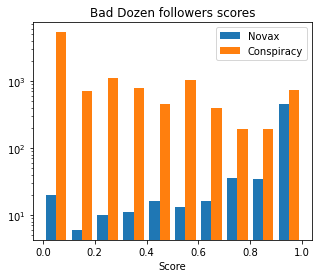

In [166]:
plt.hist([bad_avaxtar["score"], bad_score["conspiracy_score"]], label=['Novax', 'Conspiracy'])
plt.legend(loc='upper right')
plt.rcParams["figure.figsize"] = (13,8)
plt.title("Bad Dozen followers scores")
plt.yscale('log', nonposy='clip')
plt.xlabel("Score")
plt.show()

In [254]:
lst = ["bad" for i in range(len(bad_avaxtar))]
bad_avaxtar["dozen"] = lst
lst = ["good" for i in range(len(good_avaxtar))]
good_avaxtar["dozen"] = lst
avax_merged = bad_avaxtar.append(good_avaxtar)
fig = px.box(avax_merged, x="score", color="dozen", title="Novax score box plot", 
                            labels={
                            "dozen" : "Kind of user",
                            "conspiracy_score" : "Score from 0 to 1"
                            },
                          color_discrete_sequence=["blue", "red"]
                            )
fig.show()

# Interaction between Good and Bad Dozen
<a id="interaction"/>

In [51]:
df_bad_dozen_interactions[df_bad_dozen_interactions["rt_user_screen_name"].isin(list(good_dozen_list["screen_name"]))]

,id,created_at,user_id,user_screen_name,retweet_count,in_reply_to_user_id,in_reply_to_screen_name,rt_user_id,rt_user_screen_name,hashtags,urls


In [52]:
df_good_dozen_interactions[df_good_dozen_interactions["rt_user_screen_name"].isin(list(bad_dozen_list["screen_name"]))]

,id,id_str,created_at,user_id,user_screen_name,user_verified,user_created_at,user_tweets_count,user_friends_count,user_followers_count,...,quoted_status_text,quoted_status_created_at,quoted_user_id,quoted_user_created_at,hashtags,symbols,user_mentions,urls,polls,media


### Interaction between Good Dozen


In [28]:
reply_v = df_good_activity[["user_screen_name", "in_reply_to_screen_name"]]
rp_prova = reply_v[reply_v["in_reply_to_screen_name"].isin(list(good_users_list["screen_name"]))]
rp_prova 

,user_screen_name,in_reply_to_screen_name
9,juliaoftoronto,juliaoftoronto
17,KrutikaKuppalli,alexandraphelan
55,IsabelOtt,IsabelOtt
73,IsabelOtt,IsabelOtt
74,IsabelOtt,IsabelOtt
...,...,...
750756,richardneher,pathogenomenick
750757,richardneher,pathogenomenick
750761,richardneher,EvolveDotZoo
750762,richardneher,arambaut


### Interaction between Bad Dozen


In [29]:
reply = df_bad_activity[["user_screen_name", "in_reply_to_screen_name"]]
reply[reply["in_reply_to_screen_name"].isin(list(bad_dozen_list["screen_name"]))]

,user_screen_name,in_reply_to_screen_name
43,BusyDrT,BusyDrT
90,BusyDrT,BusyDrT
212,mercola,mercola
226,mercola,mercola
231,mercola,mercola
...,...,...
18002,DrChrisNorthrup,BusyDrT
18003,DrChrisNorthrup,BusyDrT
20202,kevdjenkins1,kevdjenkins1
21877,kevdjenkins1,kevdjenkins1


# Reply investigation
<a id="reply_inv"/>

In [30]:
x = reply_v[reply_v["in_reply_to_screen_name"].isin(list(good_users_list["screen_name"]))]

In [31]:
x = x.reset_index(drop=True)
self_rep = []
for i in range(len(x["user_screen_name"])):
    if x["user_screen_name"][i] == x["in_reply_to_screen_name"][i]:
        self_rep.append(x["user_screen_name"][i])

In [32]:
l = x["user_screen_name"].value_counts()

In [33]:
sum(reply_v["user_screen_name"].value_counts())

750820

In [34]:
f = pd.Series(self_rep).value_counts().sort_values(ascending=False)

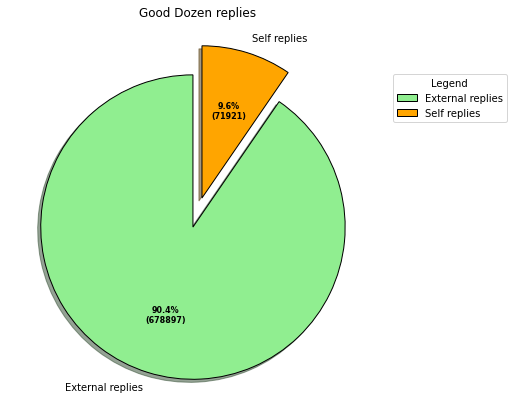

In [35]:
data =[(sum(reply_v["user_screen_name"].value_counts())-sum(f)), sum(f)]
label = ["External replies", "Self replies"]
explode = (0.1, 0.1)
# Creating color parameters
colors = ( "lightgreen", "orange")

# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct = lambda pct: func(pct, data),
                                  explode = explode, 
                                  labels = label,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp)

# Adding legend
ax.legend(wedges, label,
          title ="Legend",
          loc ="center left",
          bbox_to_anchor =(1, 0.3, 0.5, 1))

plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Good Dozen replies")
plt.show()

In [23]:
value = 0
for i in f:
    value = value + i

In [24]:
len_internal_reply =len(reply_v[reply_v["in_reply_to_screen_name"].isin(list(good_dozen_list["screen_name"]))])
len_total_reply = len(reply_v)
print(f"Good dozen internal replies are {round(len_internal_reply/len_total_reply,4)*100}% of total")
print(f"Good dozen self-replies are {round(value/len_total_reply,4)*100}% of total")

Good dozen internal replies are 53.12% of total
Good dozen self-replies are 52.5% of total


### File Botometer
<a id="bom"/>

In [72]:
x1 = pd.read_csv(path[0] + "rt_good.csv")

In [38]:
x2 = pd.read_csv(path[0] + "retweet_users_ccdh.csv", usecols=["user_screen_name"])

In [41]:
same = x2[x2["user_screen_name"].isin(x["user_screen_name"])]

In [60]:
path = "C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/to_be_scored/"

In [61]:
path = glob.glob(path + "/*.csv")

In [65]:
df_bom = pd.DataFrame()
for i in path:
    df_bom = df_bom.append(pd.read_csv(i, usecols=["screen_name"]))
df_bom = df_bom.reset_index(drop = True)
df_bom

,screen_name
0,matomecorona
1,TomthunkitsMind
2,Host24Space
3,CoronaVirusNFO
4,Dooiz1
...,...
99995,TOIDelhi
99996,LauraSmithCrewe
99997,mstewart_23
99998,nickmangwana


In [67]:
df_bom.drop_duplicates(subset ="screen_name", keep = False, inplace = True)
df_bom = df_bom.reset_index(drop = True)

In [75]:
diff = diff.reset_index(drop = True)

In [77]:
df_tbs_good = x[~x["user_screen_name"].isin(df_bom["screen_name"])]
df_tbs_bad = x2[~x2["user_screen_name"].isin(df_bom["screen_name"])]
df_tbs_same = same[~same["user_screen_name"].isin(df["screen_name"])]
df_tbs_good = df_tbs_good.reset_index(drop = True)
df_tbs_bad = df_tbs_bad.reset_index(drop = True)
df_tbs_same = df_tbs_same.reset_index(drop = True)
path_tbs = "C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/to_be_scored/"
df_tbs_good.to_csv(path_tbs + "good_rt.csv", index = False, encoding="utf-8", line_terminator="\n")
df_tbs_bad.to_csv(path_tbs + "bad_rt.csv", index = False, encoding="utf-8", line_terminator="\n")
df_tbs_same.to_csv(path_tbs + "same_rt.csv", index = False, encoding="utf-8", line_terminator="\n")

In [81]:
path_tbs = "C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/to_be_scored/"
df_tbs_good.to_csv(path_tbs + "good_rt.csv", index = False, encoding="utf-8", line_terminator="\n")
df_tbs_bad.to_csv(path_tbs + "bad_rt.csv", index = False, encoding="utf-8", line_terminator="\n")
df_tbs_same.to_csv(path_tbs + "same_rt.csv", index = False, encoding="utf-8", line_terminator="\n")

### Regression: Degree - Score
<a id="degscore"/>

In [89]:
path_degrees = glob.glob("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/large_files/rt_network/degree.json")[0]
path_louvain = glob.glob("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/large_files/rt_network/*louvain*.json")[0]
start_time = time.perf_counter()
file = open (path_degrees)
degree = json.loads(file.read())
file.close()
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)
start_time = time.perf_counter()
file = open (path_louvain)
louvain = json.loads(file.read())
file.close()
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)

Time:  88.84981900000002
Time:  26.507505200000196


In [24]:
names = list(scores["user_screen_name"])

In [98]:
nm = []
com = []
for i in louvain:
    nm.append(i)
    com.append(louvain.get(i))


In [99]:
df_louvain = pd.DataFrame(list(zip(nm, com)),
               columns =['name', 'community'])

In [25]:
x = []
y = []
for i in degree:
#     if i[0] in list(scores["user_screen_name"]):
#         x.append(float(scores.loc[scores["user_screen_name"] == i[0]]["conspiracy_score"]))
#         y.append(i[1])
    x.append(i[0])
    y.append(i[1])


In [26]:
df_degree = pd.DataFrame(list(zip(x, y)),
               columns =['name', 'degree'])

In [103]:
df_nodes = df_louvain.merge(df_degree, left_on="name", right_on="name", how="left")

In [106]:
df_merge = scores_dozen.merge(df_nodes, left_on='user_screen_name', right_on='name', how="left")
df_merge

,user_screen_name,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,dozen,name,community,degree
0,KeiserOla,12.0,0.0,1.0,9.0,2.0,1.0,common,KeiserOla,2.0,16.0
1,Breinbrouwsels,25.0,0.0,2.0,19.0,4.0,1.0,common,Breinbrouwsels,2.0,60.0
2,PABurch,12.0,0.0,1.0,1.0,10.0,1.0,common,NaN,NaN,NaN
3,CristianeWynnie,12.0,0.0,1.0,11.0,0.0,1.0,common,CristianeWynnie,32.0,39.0
4,ak2webd3,12.0,0.0,1.0,9.0,2.0,1.0,good,ak2webd3,2.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...
144443,Gus_802,15.0,2.0,0.0,3.0,10.0,0.0,common,Gus_802,1.0,48.0
144444,FemiJelena,15.0,3.0,0.0,7.0,5.0,0.0,bad,FemiJelena,2.0,27.0
144445,tunde_adenuga,15.0,3.0,0.0,10.0,2.0,0.0,common,tunde_adenuga,19.0,33.0
144446,Teensthack,15.0,2.0,0.0,10.0,3.0,0.0,common,Teensthack,6.0,317.0


In [109]:
df_merge_notna = df_merge[df_merge["degree"].notna()].reset_index(drop=True)
df_merge_notna

,user_screen_name,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,dozen,name,community,degree
0,KeiserOla,12.0,0.0,1.0,9.0,2.0,1.0,common,KeiserOla,2.0,16.0
1,Breinbrouwsels,25.0,0.0,2.0,19.0,4.0,1.0,common,Breinbrouwsels,2.0,60.0
2,CristianeWynnie,12.0,0.0,1.0,11.0,0.0,1.0,common,CristianeWynnie,32.0,39.0
3,ak2webd3,12.0,0.0,1.0,9.0,2.0,1.0,good,ak2webd3,2.0,42.0
4,jdmcnamara,12.0,0.0,1.0,11.0,0.0,1.0,common,jdmcnamara,2.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...
140390,Gus_802,15.0,2.0,0.0,3.0,10.0,0.0,common,Gus_802,1.0,48.0
140391,FemiJelena,15.0,3.0,0.0,7.0,5.0,0.0,bad,FemiJelena,2.0,27.0
140392,tunde_adenuga,15.0,3.0,0.0,10.0,2.0,0.0,common,tunde_adenuga,19.0,33.0
140393,Teensthack,15.0,2.0,0.0,10.0,3.0,0.0,common,Teensthack,6.0,317.0


In [110]:
df_merge_notna.to_csv(path[0] + "scores_dozen_degree.csv", line_terminator="\n", encoding="utf-8", index=False)

In [111]:
df_merge_notna.corr()

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,community,degree
number_of_urls,1.000000,0.714377,0.251868,0.895497,0.379208,0.011560,-0.004711,0.133990
HIGH,0.714377,1.000000,0.139478,0.438953,0.120335,-0.059179,-0.003998,0.172384
LOW,0.251868,0.139478,1.000000,0.145876,0.048372,0.307592,-0.002388,0.028038
UNKW,0.895497,0.438953,0.145876,1.000000,0.115366,0.001570,0.000034,0.076398
SOCIAL,0.379208,0.120335,0.048372,0.115366,1.000000,0.021427,-0.012176,0.060567
conspiracy_score,0.011560,-0.059179,0.307592,0.001570,0.021427,1.000000,-0.004890,-0.014367
community,-0.004711,-0.003998,-0.002388,0.000034,-0.012176,-0.004890,1.000000,-0.005404
degree,0.133990,0.172384,0.028038,0.076398,0.060567,-0.014367,-0.005404,1.000000


<AxesSubplot:>

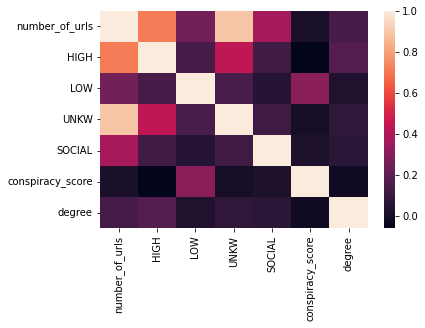

In [32]:
sns.heatmap(df_merge_notna.corr())

## SAGE
<a id="sage"/>

In [11]:
sage_path = glob.glob("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/sage/data/")
df_sage = pd.read_csv(sage_path[0] + "dozen_20.csv", low_memory=False, lineterminator="\n")
df_sage = tweets_utils.clean_data_format(df_sage) 
source = [(lambda x: x.split('\\')[2].split("_")[0])(x) for x in df_sage["source"]]
df_sage["source"] = source
df_sage

,source,word,sage,file_count,file_rate,base_count,base_rate
0,bad,thedefender,2.890878,14256,0.008407,14256,0.001963
1,bad,zook,2.890533,2965,0.001749,2965,0.000408
2,bad,classen,2.890501,2731,0.001611,2731,0.000376
3,bad,dressen,2.890208,1723,0.001016,1723,0.000237
4,bad,orthostatic,2.889652,1007,0.000594,1007,0.000139
5,bad,miller12345,2.889580,956,0.000564,956,0.000132
6,bad,enlarged,2.889522,2966,0.001749,2969,0.000409
7,bad,aldous,2.888737,1041,0.000614,1042,0.000143
8,bad,bitches,2.888536,956,0.000564,957,0.000132
9,bad,bicycled,2.888066,462,0.000272,462,0.000064


# Avaxtar
<a id="avaxtar"/>

In [179]:
path_avaxtar = glob.glob("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/csv/score_avaxtar/")[0]
bad_dozen_score = pd.read_csv(path_avaxtar + "bad_dozen.csv", lineterminator="\n", low_memory=False)
good_dozen_score = pd.read_csv(path_avaxtar + "good_users.csv", lineterminator="\n", low_memory=False)

In [168]:
good_dozen_score = good_dozen_score.drop(good_dozen_score[good_dozen_score.score == "Error"].index)
lst_score = []
[lst_score.append(float(i)) for i in good_dozen_score["score"]]
good_dozen_score["score"] = lst_score

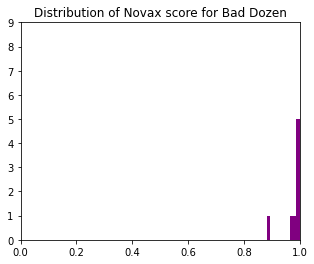

In [201]:
# data = np.array(bad_dozen_score["score"],  dtype=float)
bad_dozen_score = bad_dozen_score.drop(bad_dozen_score[bad_dozen_score.score == "Error"].index)
bad_dozen_score["score"] = bad_dozen_score["score"].astype("float")
# # Plotting
plt.rcParams["figure.figsize"] = (5,4)

plt.hist(bad_dozen_score["score"], 10, color="purple")
plt.title("Distribution of Novax score for Bad Dozen")
plt.xlim([0, 1])
plt.ylim([0, 9])
plt.show()

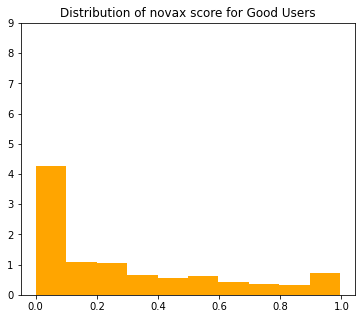

In [199]:
good_dozen_score = good_dozen_score.drop(good_dozen_score[good_dozen_score.score == "Error"].index)
good_dozen_score["score"] = good_dozen_score["score"].astype("float")
plt.hist(good_dozen_score["score"], 10, density=True, color="orange")
plt.title("Distribution of novax score for Good Users")
plt.ylim([0, 9])

plt.show()

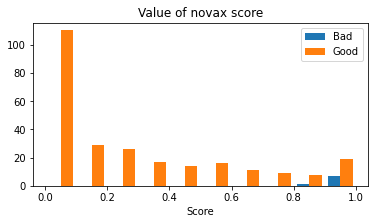

In [198]:
plt.hist([bad_dozen_score["score"], good_dozen_score["score"]], label=['Bad', 'Good'])
plt.legend(loc='upper right')
plt.rcParams["figure.figsize"] = (6,5)
plt.title("Value of novax score")
# plt.yscale('log', nonposy='clip')
plt.xlabel("Score")
plt.show()